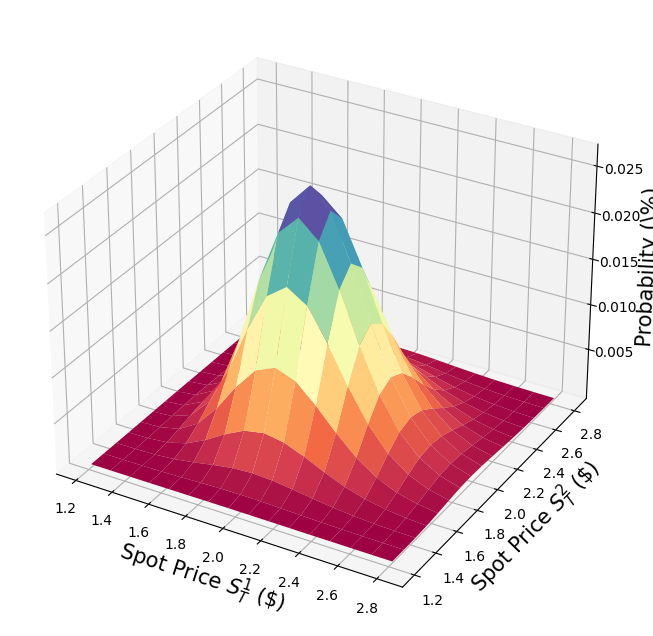

         ┌───────┐┌─────────┐       
state_0: ┤0      ├┤0        ├───────
         │       ││         │       
state_1: ┤1      ├┤1        ├───────
         │       ││         │       
state_2: ┤2      ├┤2        ├───────
         │       ││         │       
state_3: ┤3      ├┤3        ├───────
         │  P(X) ││         │       
state_4: ┤4      ├┤4        ├───────
         │       ││         │       
state_5: ┤5      ├┤5        ├───────
         │       ││         │       
state_6: ┤6      ├┤6        ├───────
         │       ││         │       
state_7: ┤7      ├┤7        ├───────
         └───────┘│         │┌─────┐
    obj: ─────────┤         ├┤5    ├
                  │         ││     │
  sum_0: ─────────┤8  adder ├┤0    ├
                  │         ││     │
  sum_1: ─────────┤9        ├┤1    ├
                  │         ││     │
  sum_2: ─────────┤10       ├┤2    ├
                  │         ││     │
  sum_3: ─────────┤11       ├┤3    ├
                  │         ││     │
 

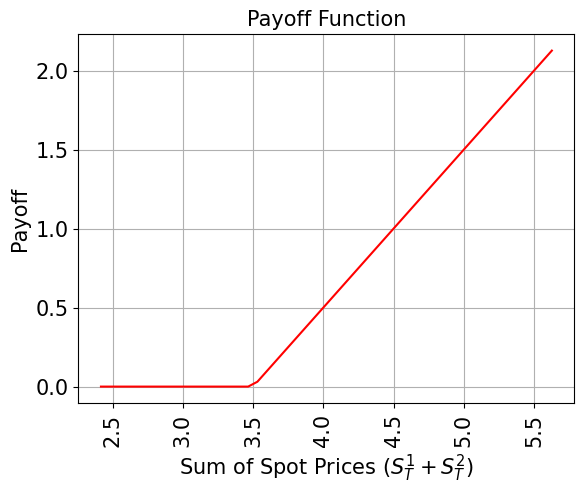

Exact expected value:	0.5269
State qubits:  9
Circuit width: 19
Circuit depth: 2075


In [2]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np

from qiskit import QuantumRegister, QuantumCircuit, AncillaRegister, transpile
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import WeightedAdder, LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

# Setup parameters
num_uncertainty_qubits = 4

# Parameters for the financial model
initial_spot_price = 2.0
volatility = 0.4
interest_rate = 0.05
days_to_maturity = 40 / 365

# Calculate derived parameters
mu = (interest_rate - 0.5 * volatility**2) * days_to_maturity + np.log(initial_spot_price)
sigma = volatility * np.sqrt(days_to_maturity)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
std_dev = np.sqrt(variance)

# Define boundaries for the spot price
low_bound = np.maximum(0, mean - 3 * std_dev)
high_bound = mean + 3 * std_dev

# Define distribution parameters
dimension = 2
num_qubits_per_dim = [num_uncertainty_qubits] * dimension
low_bound = low_bound * np.ones(dimension)
high_bound = high_bound * np.ones(dimension)
mu_vector = mu * np.ones(dimension)
cov_matrix = sigma**2 * np.eye(dimension)

# Construct quantum circuit components
distribution = LogNormalDistribution(num_qubits=num_qubits_per_dim, mu=mu_vector, sigma=cov_matrix, bounds=list(zip(low_bound, high_bound)))

# Plot probability density function
x_vals = [v[0] for v in distribution.values]
y_vals = [v[1] for v in distribution.values]
probabilities = distribution.probabilities

resolution = np.array([2**n for n in num_qubits_per_dim]) * 1j
grid_x, grid_y = np.mgrid[min(x_vals):max(x_vals):resolution[0], min(y_vals):max(y_vals):resolution[1]]
grid_z = griddata((x_vals, y_vals), probabilities, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=15)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=15)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()

# Determine necessary qubits for loss representation
weights = []
for num_q in num_qubits_per_dim:
    for i in range(num_q):
        weights += [2**i]

# Create aggregation circuit
adder = WeightedAdder(sum(num_qubits_per_dim), weights)
num_sum_qubits = adder.num_sum_qubits
num_aux_qubits = adder.num_qubits - num_sum_qubits - adder.num_state_qubits

# Define strike price within valid range
strike_price = 3.5
max_val = 2**num_sum_qubits - 1
low_bound_1d = low_bound[0]
high_bound_1d = high_bound[0]
mapped_strike_price = ((strike_price - dimension * low_bound_1d) / (high_bound_1d - low_bound_1d) * (2**num_uncertainty_qubits - 1))

# Approximation scaling for payoff function
approx_scaling = 0.25

# Piecewise linear objective function setup
breakpoints = [0, mapped_strike_price]
slopes = [0, 1]
offsets = [0, 0]
min_value = 0
max_value = 2 * (2**num_uncertainty_qubits - 1) - mapped_strike_price
objective_function = LinearAmplitudeFunction(
    num_sum_qubits,
    slopes,
    offsets,
    domain=(0, max_val),
    image=(min_value, max_value),
    rescaling_factor=approx_scaling,
    breakpoints=breakpoints,
)

# Define multivariate problem
qr_state = QuantumRegister(distribution.num_qubits, "state")
qr_objective = QuantumRegister(1, "obj")
anc_sum = AncillaRegister(num_sum_qubits, "sum")
ancillary = AncillaRegister(max(num_aux_qubits, objective_function.num_ancillas), "work")

objective_index = distribution.num_qubits

basket_option_circuit = QuantumCircuit(qr_state, qr_objective, anc_sum, ancillary)
basket_option_circuit.append(distribution, qr_state)
basket_option_circuit.append(adder, qr_state[:] + anc_sum[:] + ancillary[:num_aux_qubits])
basket_option_circuit.append(objective_function, anc_sum[:] + qr_objective[:] + ancillary[: objective_function.num_ancillas])

print(basket_option_circuit.draw())
print("objective qubit index", objective_index)

# Plot exact payoff function
x_values = np.linspace(sum(low_bound), sum(high_bound))
y_values = np.maximum(0, x_values - strike_price)
plt.plot(x_values, y_values, "r-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Sum of Spot Prices ($S_T^1 + S_T^2)$", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(size=15, rotation=90)
plt.yticks(size=15)
plt.show()

# Evaluate exact expected value
sum_of_values = np.sum(distribution.values, axis=1)
exact_expected_value = np.dot(
    distribution.probabilities[sum_of_values >= strike_price],
    sum_of_values[sum_of_values >= strike_price] - strike_price,
)
print("Exact expected value:\t%.4f" % exact_expected_value)

num_state_qubits = basket_option_circuit.num_qubits - basket_option_circuit.num_ancillas
print("State qubits: ", num_state_qubits)
transpiled_circuit = transpile(basket_option_circuit, basis_gates=["u", "cx"])
print("Circuit width:", transpiled_circuit.width())
print("Circuit depth:", transpiled_circuit.depth())


In [6]:
# Perform measurement on all qubits
measurement_circuit = basket_option_circuit.measure_all(inplace=False)

# Initialize quantum sampler and run the measurement job
quantum_sampler = Sampler()
execution_job = quantum_sampler.run(measurement_circuit)

# Initialize a variable to accumulate the value
accumulated_value = 0

# Retrieve the probability distribution from the job result
probability_distribution = execution_job.result().quasi_dists[0].binary_probabilities()

# Iterate over the probability distribution and accumulate values based on the condition
for bitstring, probability in probability_distribution.items():
    # Only consider probabilities above a certain threshold and check the condition on state qubits
    if probability > 1e-4 and bitstring[-num_state_qubits:][0] == "1":
        accumulated_value += probability

# Map the accumulated value back to the original range
mapped_accumulated_value = (
    objective_function.post_processing(accumulated_value) / (2**num_uncertainty_qubits - 1) * (high_bound_1d - low_bound_1d)
)

# Print the results
print("Accumulated Operator Value:  %.4f" % accumulated_value)
print("Mapped Operator Value: %.4f" % mapped_accumulated_value)
print("Exact Expected Payoff: %.4f" % exact_expected_value)

Accumulated Operator Value:  0.3936
Mapped Operator Value: 0.4869
Exact Expected Payoff: 0.5269


In [8]:
# Set target precision and confidence level for amplitude estimation
epsilon_target = 0.01  # Precision goal
alpha_level = 0.05     # Confidence level

# Define the estimation problem
estimation_problem = EstimationProblem(
    state_preparation=basket_option_circuit,  # The quantum circuit for state preparation
    objective_qubits=[objective_index],      # The qubit index corresponding to the objective
    post_processing=objective_function.post_processing,  # Post-processing function for the results
)

# Set up the amplitude estimation algorithm
amplitude_estimation = IterativeAmplitudeEstimation(
    epsilon_target=epsilon_target, 
    alpha=alpha_level, 
    sampler=Sampler(run_options={"shots": 100, "seed": 75})  # Sampler with specific run options
)

# Perform the amplitude estimation
estimation_result = amplitude_estimation.estimate(estimation_problem)

# Process the confidence interval
confidence_interval = (
    np.array(estimation_result.confidence_interval_processed)  # Confidence interval from result
    / (2**num_uncertainty_qubits - 1)  # Normalize based on the number of qubits
    * (high_bound_1d - low_bound_1d)  # Map back to the original range
)

# Print the exact value and estimated results
print("Exact Expected Value:    \t%.4f" % exact_expected_value)
print(
    "Estimated Value:         \t%.4f"
    % (estimation_result.estimation_processed / (2**num_uncertainty_qubits - 1) * (high_bound_1d - low_bound_1d))
)
print("Confidence Interval:     \t[%.4f, %.4f]" % tuple(confidence_interval))


: 